In [1]:
import random
import csv

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys
from scipy.signal import find_peaks
from tqdm import tqdm

from utils.eval.eval_utils import evaluate_peaks, compute_ROC
from utils.training.metrics import accuracy_for_segmenter, AUC_for_segmenter
from utils.training.data_loading import lines_to_line_generator, get_line_to_spectro_seg, get_load_spectro_for_class
from utils.training.keras_models import time_segmenter_model, resnet_model

2023-12-06 16:16:21.142832: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 16:16:21.168488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 16:16:21.168511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 16:16:21.168526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 16:16:21.173463: I tensorflow/core/platform/cpu_feature_g

In [7]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/HYDROMOMAR_2013/spectrograms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/OHASISBIO_2020/spectrograms"
BATCH_SIZE = 64
CHECKPOINT = "/media/plerolland/LaBoite/PublicData/trainings/checkpoints_auc_acc/checkpoints_classif/all/cp-0031.ckpt"

SIZE = 224
CHANNELS = 3

ALLOWED_ERROR_S = 10  # tolerance when evaluating and time distance allowed between two peaks in the probabilities distribution
OUTPUT_FILES_SUFFIX = "resnet_oha2020"

load = get_load_spectro_for_class(SIZE, CHANNELS)
model = resnet_model
m = model()
m.load_weights(CHECKPOINT)
m.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.binary_crossentropy,
            metrics=['Accuracy','AUC'])

In [8]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
print(len(lines), "files found")
lines = [l[0] for l in lines]
dataset = tf.data.Dataset.from_tensor_slices(lines)
dataset = dataset.map(load).batch(batch_size=BATCH_SIZE)

31104 files found


In [12]:
history = m.evaluate(dataset,
            batch_size=BATCH_SIZE)

324/324 [==============================] - 114s 349ms/step - loss: 0.3760 - Accuracy: 0.9030 - auc: 0.7849


In [9]:
detected = []
ground_truth = []

for images, y in tqdm(dataset, total=1+int(len(lines)/BATCH_SIZE)):
    predicted = m.predict(images, verbose=False)
    detected.extend(predicted[:,0])
    ground_truth.extend(y)
    
detected = np.array(detected)
ground_truth = np.array(ground_truth)    

 37%|███▋      | 178/487 [01:13<02:06,  2.45it/s]

100%|█████████▉| 486/487 [03:20<00:00,  2.43it/s]


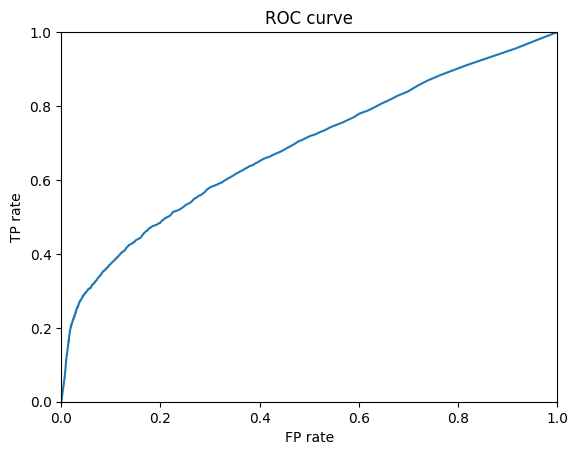

In [10]:
TPr, FPr = compute_ROC(detected[ground_truth==1], np.count_nonzero(ground_truth==1), detected[ground_truth==0], np.count_nonzero(ground_truth==0), thresh_delta=0.001)
plt.plot(FPr, TPr)
np.save(f"data/FPr_{OUTPUT_FILES_SUFFIX}.npy", FPr)
np.save(f"data/TPr_{OUTPUT_FILES_SUFFIX}.npy", TPr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.title("ROC curve")
plt.savefig(f"data/ROC_{OUTPUT_FILES_SUFFIX}.png")